# User agent analysis

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
g = threatgraph.Gaffer()
g.use_cert()

In [3]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("useragent")
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

useragents = {}
timestamps = {}
counts = {}

all_useragents = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    ua = list(ent["entities"][2].keys())[0]
    
    # Truncate user-agent string
    ua = ua[:30]
    k = (dev, ua)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in useragents:
        useragents[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    useragents[dev].add(ua)
    all_useragents.add(ua)
    all_devices.add(dev)

In [4]:
all_devices = list(all_devices)
all_useragents = list(all_useragents)

## Construct heatmap matrix

In [5]:
def yeh(ua, dev):
    if ua in useragents[dev]: return counts[(dev, ua)]
    return 0

datas = [ [ yeh(ua, dev) for dev in all_devices ] for ua in all_useragents]
df = pd.DataFrame(datas, index=all_useragents, columns=all_devices)

In [6]:
my_fn = lambda x: np.log(x + 0.001)
df["score"] = df.sum(axis=1)
df[all_devices] = df[all_devices].apply(my_fn)
df = df.sort_values(by="score", ascending=False)
df

,turing-chromebook,abroad-android,dgmac,terrestrial-mac,traverses-mac,elysium-mac,DESKTOP-PIMD8C0,boundless-mac,LAPTOP-1I501C4U,mark-mac,...,calcannea-mac,steamverne-mac,simon-macpro,rarb-mac,nervings-cb,minesweepers-mac,serotinal-mac,essential-chrome,essential-cb,score
Mozilla/5.0 (Macintosh; Intel,3.044570,-6.907755,0.693647,8.985070,1.946053,7.626083,-6.907755,10.371990,-6.907755,7.098376,...,0.001000,7.348588,6.003890,4.584978,-6.907755,7.805067,8.225503,-6.907755,-6.907755,84889
Roblox/Darwin,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,52436
Mozilla/5.0 (X11; CrOS x86_64,5.828949,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,8.663888,-6.907755,-6.907755,4.962852,7.932721,24004
Microsoft-Delivery-Optimizatio,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,8.602270,-6.907755,8.602270,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,10940
Mozilla/5.0 EA Download Manage,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,8031
ProtoHttp 1.3/DS 15.1.2.3.0 (A,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,5920
python-requests/2.13.0,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,4558
Mozilla/5.0 (X11; Ubuntu; Linu,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,...,-6.907755,8.366603,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,4301
Mozilla/5.0 (Linux; Android 6.,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,8.106515,-6.907755,-6.907755,...,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,3727
trustd (unknown version) CFNet,0.693647,-6.907755,1.098946,6.486162,3.465767,5.953246,-6.907755,6.228513,-6.907755,4.454359,...,-6.907755,4.718508,5.342339,4.043069,-6.907755,5.036959,5.837733,-6.907755,-6.907755,3647


## Plot heatmap

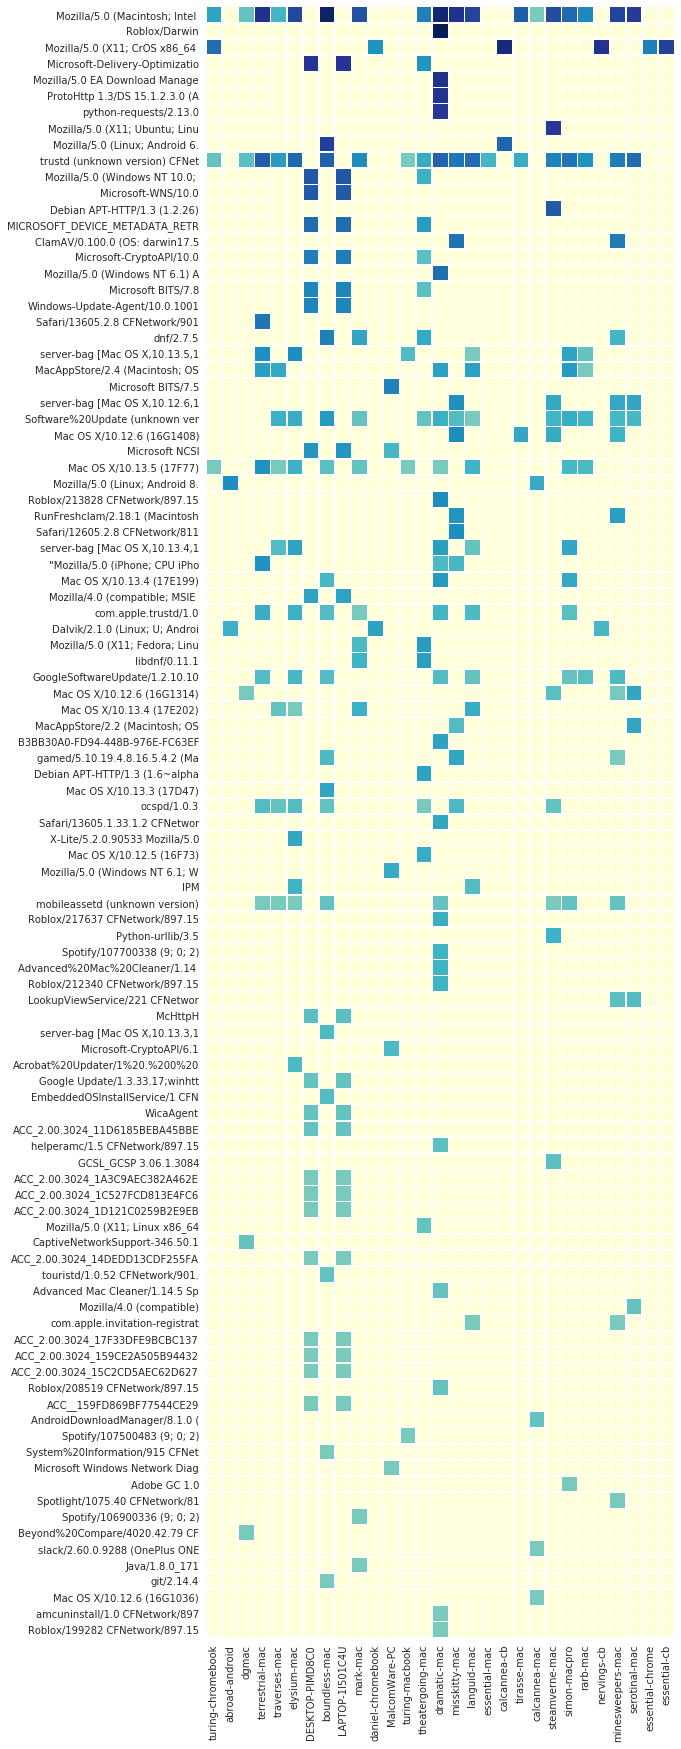

In [7]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df[all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()